In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
from random import randint
import pandas as pd

In [2]:
class DatabaseOptimizer:
    
    def __init__(self, 
                 smiles_list,
                 desired_library_size,
                 fp_rad=2,
                 fp_bits=1024):
        
        self.smiles_list = smiles_list
        self.desired_library_size = desired_library_size
        self.rad = fp_rad
        self.bits = fp_bits
        
        self.n_molecules = len(smiles_list)
        self.fp_dict = self.calc_fp_dict()
        self.sums = np.zeros((self.n_molecules))
        self.optimized_library = []


    def optimize(self):
        index = randint(0, self.n_molecules)
        self.update_subsets(index)
        self.optimized_library.append(smiles_list[index])

        n = 1
        while n < self.desired_library_size:
            next_molecule, index = self.next_molecule()
            self.update_subsets(index)

            self.optimized_library.append(next_molecule)
            
            if n % 500 == 0:
                print('{} molecules added to library'.format(n))
            n += 1
           
        
    def update_subsets(self, index):
        similarities = np.array([self.calc_similarity(smiles_list[index], smiles2) for smiles2 in self.smiles_list])
        self.sums += similarities
            
        del self.smiles_list[index]
        self.sums = np.delete(self.sums, index, 0)        
        
        
    def calc_similarity(self, smi1, smi2):
        similarity = DataStructs.TanimotoSimilarity(self.fp_dict[smi1], self.fp_dict[smi2])
        return similarity
        
            
    def next_molecule(self):
        index = self.sums.argsort()[0] 
        next_molecule = smiles_list[index]
        return next_molecule, index
    

    def calc_fp_dict(self):
        print('Calculating fingerprints...')
        fp_dict = {smiles:self.calc_fp(smiles) for smiles in self.smiles_list}
        print('Fingerprint calculations complete...')
        return fp_dict


    def calc_fp(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.rad, nBits=self.bits)
        return fp

    
    def calc_library_similarities(self, library):
        n = len(library)
        similarities = []
        for i in range(n):
            for j in range(i+1, n):
                similarities.append(self.calc_similarity(library[i], library[j]))
        return similarities



In [3]:
with open('./monomer-smiles-substituted.csv') as f:
    smiles_list = [line.split()[1] for line in f]
    
random_set = pd.DataFrame(smiles_list).sample(50000)

In [ ]:
optimizer = DatabaseOptimizer(smiles_list, 50000)
optimizer.optimize()

Calculating fingerprints...
Fingerprint calculations complete...
500 molecules added to library
1000 molecules added to library
1500 molecules added to library
2000 molecules added to library
2500 molecules added to library
3000 molecules added to library
3500 molecules added to library


In [28]:
x = [i for i in random_set[0]]

In [29]:
pre_opt_sims = optimizer.calc_library_similarities(x)
post_opt_sims = optimizer.calc_library_similarities(optimizer.optimized_library)

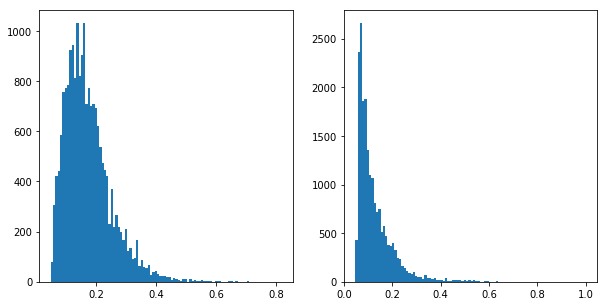

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(pre_opt_sims, bins=100)
ax[1].hist(post_opt_sims, bins=100)

plt.show()

In [31]:
print(np.sum(pre_opt_sims)/len(post_opt_sims))
print(np.sum(post_opt_sims)/len(post_opt_sims))


0.17351505741122633
0.12477675686837875
